In [18]:
import torch
from torch import nn 
from torch import optim
from torch.optim import lr_scheduler
from torch.utils.data import Dataset, random_split

from datasets import load_dataset
from tokenizers import Tokenizer
from tokenizers.models import WordLevel
from tokenizers.trainers import WordLevelTrainer
from tokenizers.pre_tokenizers import Whitespace

from pathlib import Path
import json, os

ModuleNotFoundError: No module named 'datasets'

In [7]:
class BilingualDataset(Dataset):

    def __init__(self, ds, tokenizer_src, tokenizer_tgt, src_lang, tgt_lang, seq_len):
        super().__init__()
        self.seq_len = seq_len

        self.ds = ds
        self.tokenizer_src = tokenizer_src
        self.tokenizer_tgt = tokenizer_tgt
        self.src_lang = src_lang
        self.tgt_lang = tgt_lang

        self.sos_token = torch.tensor([tokenizer_tgt.token_to_id("[SOS]")], dtype=torch.int64)
        self.eos_token = torch.tensor([tokenizer_tgt.token_to_id("[EOS]")], dtype=torch.int64)
        self.pad_token = torch.tensor([tokenizer_tgt.token_to_id("[PAD]")], dtype=torch.int64)

    def __len__(self):
        return len(self.ds)

    def __getitem__(self, idx):
        src_target_pair = self.ds[idx]
        src_text = src_target_pair['translation'][self.src_lang]
        tgt_text = src_target_pair['translation'][self.tgt_lang]

        # Transform the text into tokens
        enc_input_tokens = self.tokenizer_src.encode(src_text).ids
        dec_input_tokens = self.tokenizer_tgt.encode(tgt_text).ids

        # Add sos, eos and padding to each sentence
        enc_num_padding_tokens = self.seq_len - len(enc_input_tokens) - 2  # We will add <s> and </s>
        # We will only add <s>, and </s> only on the label
        dec_num_padding_tokens = self.seq_len - len(dec_input_tokens) - 1

        # Make sure the number of padding tokens is not negative. If it is, the sentence is too long
        if enc_num_padding_tokens < 0 or dec_num_padding_tokens < 0:
            raise ValueError("Sentence is too long")

        # Add <s> and </s> token
        encoder_input = torch.cat(
            [
                self.sos_token,
                torch.tensor(enc_input_tokens, dtype=torch.int64),
                self.eos_token,
                torch.tensor([self.pad_token] * enc_num_padding_tokens, dtype=torch.int64),
            ],
            dim=0,
        )

        # Add only <s> token
        decoder_input = torch.cat(
            [
                self.sos_token,
                torch.tensor(dec_input_tokens, dtype=torch.int64),
                torch.tensor([self.pad_token] * dec_num_padding_tokens, dtype=torch.int64),
            ],
            dim=0,
        )

        # Add only </s> token
        label = torch.cat(
            [
                torch.tensor(dec_input_tokens, dtype=torch.int64),
                self.eos_token,
                torch.tensor([self.pad_token] * dec_num_padding_tokens, dtype=torch.int64),
            ],
            dim=0,
        )

        # Double check the size of the tensors to make sure they are all seq_len long
        assert encoder_input.size(0) == self.seq_len
        assert decoder_input.size(0) == self.seq_len
        assert label.size(0) == self.seq_len

        return {
            "encoder_input": encoder_input,  # (seq_len)
            "decoder_input": decoder_input,  # (seq_len)
            "encoder_mask": (encoder_input != self.pad_token).unsqueeze(0).unsqueeze(0).int(), # (1, 1, seq_len)
            "decoder_mask": (decoder_input != self.pad_token).unsqueeze(0).int() & causal_mask(decoder_input.size(0)), # (1, seq_len) & (1, seq_len, seq_len),
            "label": label,  # (seq_len)
            "src_text": src_text,
            "tgt_text": tgt_text,
        }
    
def causal_mask(size):
    mask = torch.triu(torch.ones((1, size, size)), diagonal=1).type(torch.int)
    return mask == 0

In [10]:
def get_or_build_tokenizer(config, ds, lang):
    tokenizer_path = Path(config['tokenizer_file'].format(lang))
    if not Path.exists(tokenizer_path):
        # Most code taken from: https://huggingface.co/docs/tokenizers/quicktour
        tokenizer = Tokenizer(WordLevel(unk_token="[UNK]"))
        tokenizer.pre_tokenizer = Whitespace()
        trainer = WordLevelTrainer(special_tokens=["[UNK]", "[PAD]", "[SOS]", "[EOS]"], min_frequency=2)
        tokenizer.train_from_iterator(get_all_sentences(ds, lang), trainer=trainer)
        tokenizer.save(str(tokenizer_path))
    else:
        tokenizer = Tokenizer.from_file(str(tokenizer_path))
    return tokenizer

In [23]:
def get_all_sentences(ds, lang):
    for item in ds:
        yield item['translation'][lang]

In [25]:
def get_ds(config):
    # It only has the train split, so we divide it overselves
    ds_raw = load_dataset(f"{config['datasource']}", f"{config['lang_src']}-{config['lang_tgt']}", split='train')
    # print(ds_raw)
    # for i, item in enumerate(ds_raw):
    #     if i == 10:
    #         break
    #     print(item['translation']['it'])
    # Build tokenizers
    tokenizer_src = get_or_build_tokenizer(config, ds_raw, config['lang_src'])
    tokenizer_tgt = get_or_build_tokenizer(config, ds_raw, config['lang_tgt'])

    # # Keep 90% for training, 10% for validation
    train_ds_size = int(0.9 * len(ds_raw))
    val_ds_size = len(ds_raw) - train_ds_size
    train_ds_raw, val_ds_raw = random_split(ds_raw, [train_ds_size, val_ds_size])

    train_ds = BilingualDataset(train_ds_raw, tokenizer_src, tokenizer_tgt, config['lang_src'], config['lang_tgt'], config['seq_len'])
    val_ds = BilingualDataset(val_ds_raw, tokenizer_src, tokenizer_tgt, config['lang_src'], config['lang_tgt'], config['seq_len'])

    # Find the maximum length of each sentence in the source and target sentence
    max_len_src = 0
    max_len_tgt = 0

    for item in ds_raw:
        src_ids = tokenizer_src.encode(item['translation'][config['lang_src']]).ids
        tgt_ids = tokenizer_tgt.encode(item['translation'][config['lang_tgt']]).ids
        max_len_src = max(max_len_src, len(src_ids))
        max_len_tgt = max(max_len_tgt, len(tgt_ids))

    print(f'Max length of source sentence: {max_len_src}')
    print(f'Max length of target sentence: {max_len_tgt}')
    

    train_dataloader = DataLoader(train_ds, batch_size=config['batch_size'], shuffle=True)
    val_dataloader = DataLoader(val_ds, batch_size=1, shuffle=True)

    return train_dataloader, val_dataloader, tokenizer_src, tokenizer_tgt

In [11]:
def get_config():
    return {
        "batch_size": 8,
        "num_epochs": 20,
        "lr": 10**-4,
        "seq_len": 350,
        "d_model": 512,
        "datasource": 'opus_books',
        "lang_src": "en",
        "lang_tgt": "it",
        "model_folder": "weights",
        "model_basename": "tmodel_",
        "preload": "latest",
        "tokenizer_file": "tokenizer_{0}.json",
        "experiment_name": "runs/tmodel"
    }

In [26]:
config = get_config()
get_ds(config)

True

In [117]:
def load_sentences_dataset(input_file:str) -> tuple[list, set, int]:
    sentences = []
    tokens = set()
    max_seq_len = 0
    with open(input_file, mode='r', encoding='utf-8') as f:
        for line in f:
            sent_dict = json.loads(line.strip())
            sentences.append(sent_dict['sentence'])
            max_seq_len = max(max_seq_len, sent_dict['word_count'])
            tokens.update(sent_dict['sentence'])
        f.close()
    return sentences, tokens, max_seq_len

In [122]:
def create_vocab_ids(tokens:set, special_tokens:list=None, vocab_file:str=None, forced:bool=False) -> tuple[dict, int]:
    if forced == False and vocab_file != None and os.path.exists(vocab_file):
        with open(vocab_file, mode='r', encoding='utf-8') as f:
            vocab = json.loads(f.read().strip())
            f.close()
            print(f"Load vocab from file: {vocab_file}")
        return vocab, len(vocab)

    vocab = {}
    start_idx = 0
    if special_tokens == None:
        vocab = {
            "<SOS>": 0,
            "<EOS>": 1,
            "<PAD>": 2,
            "<UNK>": 3
        }
        start_idx = 4
    else:
        for i, token in enumerate(special_tokens):
            vocab[token] = i
        start_idx = len(special_tokens)
        
    for i, token in enumerate(tokens, start_idx):
        vocab[token] = i
        
    with open(vocab_file, mode='w', encoding='utf-8') as f:
        str_json = json.dumps(vocab, ensure_ascii=False).encode('utf-8')
        f.write(str_json.decode())
        f.close()
    return vocab, len(vocab)

In [ ]:
# %%timeit 
src_file = "data/viwiki-words.txt"
vocab_file = "data/viwiki-vocab.json"
sentences, tokens, max_seq_len = load_sentences_dataset(src_file)
create_vocab_ids(tokens, vocab_file=vocab_file)

In [1]:
from underthesea import word_tokenize, sent_tokenize
import string

In [22]:
def _replace_ending_sentence(sent:str):
    patterns = {
        '?.': '?',
        '!.': '!',
        '...': '.',
        '....': '.'
    }
    for k, v in patterns.items():
        if sent.endswith(k):
            sent = sent.replace(k, v)
    return sent

In [29]:
txt = "Phiên trước đó, giá mỗi loại đã giảm hơn 3%. Thị trường đi xuống khi nhà đầu tư lo ngại nguồn cung năm nay tăng lên, trong bối cảnh nhu cầu dầu tại Mỹ có khả năng yếu đi."

In [30]:
for sent in sent_tokenize(txt):
    print(_replace_ending_sentence(sent))

Phiên trước đó, giá mỗi loại đã giảm hơn 3%.
Thị trường đi xuống khi nhà đầu tư lo ngại nguồn cung năm nay tăng lên, trong bối cảnh nhu cầu dầu tại Mỹ có khả năng yếu đi.


In [34]:
output_file = "export/fin_{0}_sentences.txt"
output_file.format('ttt')

'export/fin_ttt_sentences.txt'

In [ ]:
tokens = word_tokenize(txt)
tokens, set(tokens)

In [2]:
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [142]:
import torch
from torch import nn 
from torch import optim
from torch.optim import lr_scheduler
from functools import partial
import matplotlib.pyplot as plt

In [16]:
def _get_linear_schedule_with_warmup_lr_lambda(current_step: int, num_warmup_steps: int, num_training_steps: int):
    if current_step < num_warmup_steps:
        return float(current_step) / float(max(1, num_warmup_steps))
    return max(0.0, float(num_training_steps - current_step) / float(max(1, num_training_steps - num_warmup_steps)))

In [192]:
def _lr_epoch_lambda(step:int, *, base_lr:float, scale:float):
    return base_lr / (1 + scale * step)

def _lr_noam_lambda(step:int, *, embed_dim:int, warmup_steps:int):    
    step += 1
    return (embed_dim ** (-0.5)) * min(step ** (-0.5), step * warmup_steps ** (-1.5))

def _lr_warmup_lambda(step:int, *, warmup_steps:int):
    step += 1
    return (warmup_steps ** (0.5)) * min(step ** (-0.5), step * warmup_steps ** (-1.5))



0 Learning Rate = 0.010000000000000002
1 Learning Rate = 0.009090909090909092
2 Learning Rate = 0.008333333333333335
3 Learning Rate = 0.007692307692307693
4 Learning Rate = 0.007142857142857144
5 Learning Rate = 0.006666666666666667
6 Learning Rate = 0.00625
7 Learning Rate = 0.0058823529411764705
8 Learning Rate = 0.005555555555555557
9 Learning Rate = 0.005263157894736843
10 Learning Rate = 0.005000000000000001
11 Learning Rate = 0.004761904761904762
12 Learning Rate = 0.004545454545454546
13 Learning Rate = 0.004347826086956523
14 Learning Rate = 0.004166666666666667
15 Learning Rate = 0.004
16 Learning Rate = 0.0038461538461538464
17 Learning Rate = 0.003703703703703704
18 Learning Rate = 0.003571428571428572
19 Learning Rate = 0.0034482758620689655
20 Learning Rate = 0.0033333333333333335
21 Learning Rate = 0.0032258064516129032
22 Learning Rate = 0.003125
23 Learning Rate = 0.0030303030303030307
24 Learning Rate = 0.0029411764705882353
25 Learning Rate = 0.0028571428571428576
26

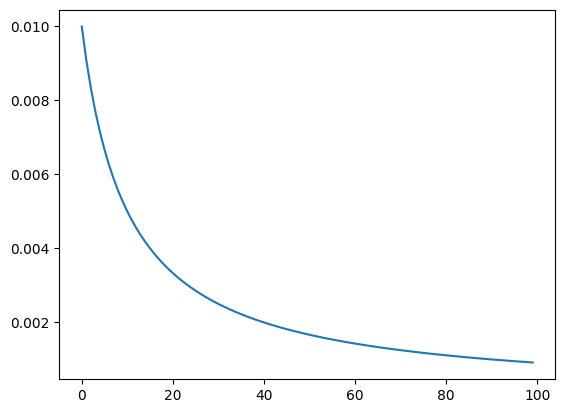

In [202]:
n = 100
embed_dim = 576
warmup_steps = 30
base_lr = 0.1

model = torch.nn.Linear(2, 1)
optimizer = optim.Adam(params=model.parameters(), lr=base_lr)

lr_epoch_lambda = partial(_lr_epoch_lambda, base_lr=base_lr, scale=0.1)
lr_noam_lambda = partial(_lr_noam_lambda, embed_dim=embed_dim, warmup_steps=warmup_steps)
lr_warmup_lambda = partial(_lr_warmup_lambda, warmup_steps=warmup_steps)
scheduler = lr_scheduler.LambdaLR(optimizer, lr_lambda=lr_epoch_lambda)
# scheduler = lr_scheduler.LambdaLR(optimizer, lr_lambda=lr_noam_lambda)
# scheduler = lr_scheduler.LambdaLR(optimizer, lr_lambda=lr_warmup_lambda)
lrs = []
for i in range(n):
    
    optimizer.step()
    lrs.append(optimizer.param_groups[0]["lr"])
    print(f"{i} Learning Rate = {optimizer.param_groups[0]['lr']}")
    scheduler.step()

plt.plot(range(n),lrs)